In [50]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

root_path = "\\".join(os.getcwd().split("\\")[:-1])
cur_path = os.path.join(root_path, 'notebooks')

In [51]:
train_data = pd.read_csv(os.path.join(root_path, 'train_data.csv'), 
                         usecols=['transcription', 'action', 'object', 'location'])
val_data = pd.read_csv(os.path.join(root_path, 'valid_data.csv'),
                      usecols=['transcription', 'action', 'object', 'location'])

In [52]:
label_cols = ['action', 'object', 'location']

label2idx = {}
for col in label_cols:
    unique_labels = train_data[col].unique().tolist()
    if 'none' in unique_labels:
        nidx = unique_labels.index('none')
        unique_labels[0], unique_labels[nidx] = unique_labels[nidx], unique_labels[0]
    label2idx[col] = {v:i for i, v in enumerate(unique_labels)}
        
label2idx

{'action': {'activate': 0,
  'increase': 1,
  'change language': 2,
  'decrease': 3,
  'deactivate': 4,
  'bring': 5},
 'object': {'none': 0,
  'heat': 1,
  'Chinese': 2,
  'lights': 3,
  'volume': 4,
  'English': 5,
  'lamp': 6,
  'shoes': 7,
  'newspaper': 8,
  'socks': 9,
  'music': 10,
  'Korean': 11,
  'juice': 12,
  'German': 13},
 'location': {'none': 0, 'kitchen': 1, 'washroom': 2, 'bedroom': 3}}

In [53]:
def convert_label_str2int(x):
    act_label = label2idx['action'][x['action']]
    obj_label = label2idx['object'][x['object']]
    loc_label = label2idx['location'][x['location']]
    return [act_label, obj_label, loc_label]

In [54]:
labeled_train_data = train_data.apply(convert_label_str2int, axis=1)

In [55]:
np.array(labeled_train_data.to_list())

array([[0, 3, 1],
       [1, 1, 0],
       [2, 2, 0],
       ...,
       [5, 7, 0],
       [3, 4, 0],
       [4, 3, 1]])

In [56]:
train_data['action_label'] = train_data['action'].apply(lambda x: label2idx['action'][x])
train_data['object_label'] = train_data['object'].apply(lambda x: label2idx['object'][x])
train_data['location_label'] = train_data['location'].apply(lambda x: label2idx['location'][x])

val_data['action_label'] = val_data['action'].apply(lambda x: label2idx['action'][x])
val_data['object_label'] = val_data['object'].apply(lambda x: label2idx['object'][x])
val_data['location_label'] = val_data['location'].apply(lambda x: label2idx['location'][x])

In [57]:
train_data.head(10)

,transcription,action,object,location,action_label,object_label,location_label
0,Turn on the kitchen lights,activate,lights,kitchen,0,3,1
1,Turn up the temperature,increase,heat,none,1,1,0
2,OK now switch the main language to Chinese,change language,Chinese,none,2,2,0
3,Turn down the bathroom temperature,decrease,heat,washroom,3,1,2
4,Change the language,change language,none,none,2,0,0
5,Turn sound down,decrease,volume,none,3,4,0
6,Decrease the heating in the washroom,decrease,heat,washroom,3,1,2
7,"It’s too loud, turn it down",decrease,volume,none,3,4,0
8,Change language,change language,none,none,2,0,0
9,Turn the lights on in the kitchen,activate,lights,kitchen,0,3,1


In [58]:
val_data.head(10)

,transcription,action,object,location,action_label,object_label,location_label
0,Turn on the lights,activate,lights,none,0,3,0
1,Turn off the lights,deactivate,lights,none,4,3,0
2,Change language,change language,none,none,2,0,0
3,Pause the music,deactivate,music,none,4,10,0
4,Resume,activate,music,none,0,10,0
5,Volume down,decrease,volume,none,3,4,0
6,Turn the lights on,activate,lights,none,0,3,0
7,Switch on the lights,activate,lights,none,0,3,0
8,Lights on,activate,lights,none,0,3,0
9,Switch off the lights,deactivate,lights,none,4,3,0


In [59]:
!tensorflow --version

'tensorflow' is not recognized as an internal or external command,
operable program or batch file.


In [60]:
y_train = train_data[['action_label', 'object_label', 'location_label']].to_numpy()
y_val = val_data[['action_label', 'object_label', 'location_label']].to_numpy()

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Limit on the number of features to K features.
TOP_K = 5000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 24

class CustomTokenizer:
    def __init__(self, training_texts):
        self.train_texts = training_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, texts):
        # Vectorize training and validation texts.
        
        texts = self.tokenizer.texts_to_sequences(texts)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        texts = pad_sequences(texts, maxlen=self.max_length, 
                              truncating='post', padding='post')
        return texts
    
tokenizer = CustomTokenizer(training_texts = train_data['transcription'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(train_data['transcription'])
tokenized_val = tokenizer.vectorize_input(val_data['transcription'])

In [62]:
tokenized_train

array([[ 2,  5,  1, ...,  0,  0,  0],
       [ 2,  6,  1, ...,  0,  0,  0],
       [49, 50, 10, ...,  0,  0,  0],
       ...,
       [24, 36,  0, ...,  0,  0,  0],
       [15, 79,  0, ...,  0,  0,  0],
       [ 2, 12,  1, ...,  0,  0,  0]])

In [63]:
tokenized_val

array([[ 2,  5,  1, ...,  0,  0,  0],
       [ 2, 12,  1, ...,  0,  0,  0],
       [54, 14,  0, ...,  0,  0,  0],
       ...,
       [ 2,  1,  4, ...,  0,  0,  0],
       [ 4, 12,  0, ...,  0,  0,  0],
       [15,  6,  0, ...,  0,  0,  0]])

In [64]:
import os
import tqdm
import requests
import zipfile
URL = "https://nlp.stanford.edu/data/glove.6B.zip"

def fetch_data(url=URL, target_file='glove6B.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=4096)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)

fetch_data()

datasets already downloded :) 


In [65]:
glove_file = "glove.6B.50d.txt"
import tqdm

EMBEDDING_VECTOR_LENGTH = 50 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r', encoding='utf-8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word, i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)

100%|███████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 76601.15it/s]


In [66]:
embedding_matrix[12]

array([ 0.45341   , -0.71043998,  0.25826001, -0.015757  ,  0.14648999,
        0.031418  , -1.0812    ,  0.31885999,  0.055295  , -0.12677   ,
       -0.45668   ,  0.030006  , -0.81975001,  0.55072999,  0.15524   ,
       -0.018467  ,  0.074422  , -0.56718999, -1.55379999, -0.60282999,
        0.16099   ,  0.45486999,  0.17386   , -0.24203999,  0.38416001,
       -1.97259998,  1.01300001,  0.80808002,  0.88331997, -0.93519998,
        3.55640006,  0.56330001,  0.036648  ,  0.94055998,  0.045721  ,
        0.013343  , -0.27625   ,  0.14872999,  0.37149   , -0.15765999,
       -0.33456001,  0.71517998,  0.24446   ,  0.087958  , -0.11456   ,
        0.13934   ,  0.33379   , -0.84455001,  0.24269   , -0.66447002])

In [67]:
def recall_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    conf_mat =  tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
    all_pos_count = tf.reduce_sum(conf_mat, axis=1)
    all_pos_count = tf.where(all_pos_count==0, 1e-06, all_pos_count)
    recall = tf.divide(tf.linalg.diag_part(conf_mat), all_pos_count)
    return tf.reduce_mean(recall)

def precision_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    conf_mat =  tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
    all_pos_count = tf.reduce_sum(conf_mat, axis=0)
    all_pos_count = tf.where(all_pos_count==0, 1e-06, all_pos_count)
    precision = tf.divide(tf.linalg.diag_part(conf_mat), all_pos_count)
    return tf.reduce_mean(precision)

def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    conf_mat =  tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
    
    # Recall
    actual_pos_count = tf.reduce_sum(conf_mat, axis=1)
    actual_pos_count = tf.where(actual_pos_count==0, 1e-06, actual_pos_count)
    recall = tf.divide(tf.linalg.diag_part(conf_mat), actual_pos_count)
    
    # Precision
    pred_pos_count = tf.reduce_sum(conf_mat, axis=0)
    pred_pos_count = tf.where(pred_pos_count==0, 1e-06, pred_pos_count)
    precision = tf.divide(tf.linalg.diag_part(conf_mat), pred_pos_count)
    
    # F1-Score
    f1 = tf.math.divide((2 * tf.math.multiply(precision, recall)), tf.math.add(precision, recall)+1e-9)
    return tf.reduce_mean(f1)

In [68]:
class ActionClassifierBlock(tf.keras.layers.Layer):
    def __init__(self, name='action_block'):
        super(ActionClassifierBlock, self).__init__(name=name)
        self.layer_1 = tf.keras.layers.LSTM(units=64,
                                            dropout=0.2,
                                            recurrent_dropout=0.5,
                                            name='action_lstm'
                                           )
        self.layer_2 = tf.keras.layers.Dense(units=6, 
                                             activation='softmax',
                                             name='action'
                                            )

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x
    
class ObjectClassifierBlock(tf.keras.layers.Layer):
    def __init__(self, name='object_block'):
        super(ObjectClassifierBlock, self).__init__(name=name)
        self.layer_1 = tf.keras.layers.LSTM(units=128, 
                                            dropout=0.2, 
                                            recurrent_dropout=0.5,
                                            return_sequences=True,
                                            name='object_lstm_1'
                                           )
        self.layer_2 = tf.keras.layers.LSTM(units=32, 
                                            dropout=0.2, 
                                            recurrent_dropout=0.5,
                                            return_sequences=False,
                                            name='object_lstm_2'
                                           )
        self.layer_3 = tf.keras.layers.Dense(units=14, 
                                             activation='softmax',
                                             name='object'
                                            )

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x
    
class LocationClassifierBlock(tf.keras.layers.Layer):
    def __init__(self, name='location_block'):
        super(LocationClassifierBlock, self).__init__(name=name)
        self.layer_1 = tf.keras.layers.LSTM(units=64, 
                                            dropout=0.2, 
                                            recurrent_dropout=0.5,
                                            name='location_lstm'
                                           )
        self.layer_2 = tf.keras.layers.Dense(units=4, 
                                             activation='softmax',
                                             name='location'
                                            )

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

In [69]:
class TextMultiLabeledClassifier(tf.keras.Model):
    def __init__(self, unique_tokens, emb_size, name='classifier'):
        super(TextMultiLabeledClassifier, self).__init__(name=name)
        # self.inputs = tf.keras.layers.Input(shape=(max_seq_len,))
        self.embedding = tf.keras.layers.Embedding(input_dim=unique_tokens,
                                                   output_dim=emb_size,
                                                   trainable=True
                                                  )
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        self.action_block = ActionClassifierBlock()
        self.object_block = ObjectClassifierBlock()
        self.locat_block = LocationClassifierBlock()
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x1 = self.action_block.call(x)
        x2 = self.object_block.call(x)
        x3 = self.locat_block.call(x)
        return [x1, x2, x3]

In [70]:
tmlc = TextMultiLabeledClassifier(unique_tokens=len(tokenizer.tokenizer.word_index)+1, 
                                  emb_size=50,
                                 )

inputs = tf.keras.layers.Input(shape=(tokenizer.max_length,), name='input_layer')
outputs = tmlc(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='text_classifier')

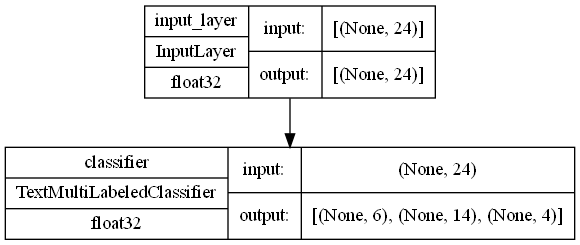

In [71]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [72]:
model.summary()

Model: "text_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24)]              0         
                                                                 
 classifier (TextMultiLabele  [(None, 6),              177198    
 dClassifier)                 (None, 14),                        
                              (None, 4)]                         
                                                                 
Total params: 177,198
Trainable params: 177,198
Non-trainable params: 0
_________________________________________________________________


In [73]:
y_train.shape

(11566, 3)

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', f1_score])

model.summary()

# fit the model
history = model.fit(tokenized_train, [y_train[:,0], y_train[:,1], y_train[:,2]], 
                    batch_size=128, 
                    epochs=10,
                    validation_data=(tokenized_val, [y_val[:, 0], y_val[:, 1], y_val[:, 2]]
                                    )
                   )

Model: "text_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 24)]              0         
                                                                 
 classifier (TextMultiLabele  [(None, 6),              177198    
 dClassifier)                 (None, 14),                        
                              (None, 4)]                         
                                                                 
Total params: 177,198
Trainable params: 177,198
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


KeyboardInterrupt: 

In [247]:
def textmulticlassifier():
    inputs = tf.keras.layers.Input(shape=(tokenizer.max_length,))
    embedding=Embedding(input_dim=len(tokenizer.tokenizer.word_index)+1, # number of unique tokens
                        output_dim=EMBEDDING_VECTOR_LENGTH, #number of features
                        # embeddings_initializer=Constant(embedding_matrix), # initialize 
                        #input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True)
    x = embedding(inputs)
    x = Dropout(rate=0.2)(x)
    x1 = LSTM(64, dropout=0.2, recurrent_dropout=0.5)(x)
    x1 = Dense(6, activation='softmax')(x1)

    x2 = LSTM(128, dropout=0.2, recurrent_dropout=0.5)(x)
    #x2 = LSTM(32, dropout=0.2, recurrent_dropout=0.5)(x2)
    x2 = Dense(14, activation='softmax')(x2)
    
    x3 = LSTM(64, dropout=0.2, recurrent_dropout=0.5)(x)
    x3 = Dense(4, activation='softmax')(x3)
    return tf.keras.Model(inputs=inputs, outputs=[x1, x2, x3])

model = textmulticlassifier()
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 embedding_54 (Embedding)       (None, 15, 50)       4950        ['input_25[0][0]']               
                                                                                                  
 dropout_64 (Dropout)           (None, 15, 50)       0           ['embedding_54[0][0]']           
                                                                                                  
 lstm_63 (LSTM)                 (None, 64)           29440       ['dropout_64[0][0]']             
                                                                                           

In [214]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [231]:
np.unique(y_train[:,2])

array([0, 1, 2, 3], dtype=int64)

In [233]:
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', f1_score])

print(model.summary())

# fit the model
history = model.fit(tokenized_train, [y_train[:,0], y_train[:,1], y_train[:,2]], 
                    batch_size=128, 
                    epochs=10,
                    validation_data=(tokenized_val, [y_val[:, 0], y_val[:, 1], y_val[:, 2]]
                                    )
                   )

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 embedding_49 (Embedding)       (None, 15, 50)       4950        ['input_20[0][0]']               
                                                                                                  
 dropout_57 (Dropout)           (None, 15, 50)       0           ['embedding_49[0][0]']           
                                                                                                  
 dropout_58 (Dropout)           (None, 15, 50)       0           ['embedding_49[0][0]']           
                                                                                           

Epoch 10/10
91/91 [==============================] - 10s 105ms/step - loss: 0.0165 - dense_57_loss: 0.0012 - dense_58_loss: 0.0139 - dense_59_loss: 0.0013 - dense_57_accuracy: 0.9999 - dense_57_f1_score: 0.9999 - dense_58_accuracy: 0.9971 - dense_58_f1_score: 0.9542 - dense_59_accuracy: 0.9998 - dense_59_f1_score: 0.9997 - val_loss: 0.0039 - val_dense_57_loss: 5.5237e-04 - val_dense_58_loss: 0.0031 - val_dense_59_loss: 2.3711e-04 - val_dense_57_accuracy: 1.0000 - val_dense_57_f1_score: 0.9533 - val_dense_58_accuracy: 1.0000 - val_dense_58_f1_score: 0.7091 - val_dense_59_accuracy: 1.0000 - val_dense_59_f1_score: 1.0000


In [174]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model=Sequential()

embedding=Embedding(input_dim=len(tokenizer.tokenizer.word_index)+1, # number of unique tokens
                    output_dim=EMBEDDING_VECTOR_LENGTH, #number of features
                    embeddings_initializer=Constant(embedding_matrix), # initialize 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    trainable=False)

model.add(embedding)
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
# compile the model
optimizer = Adam(clipvalue=0.5) # clip value to avoid the gradient exploding

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', f1_score])

print(model.summary())

# fit the model
history = model.fit(tokenized_train, y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_data=(tokenized_val, y_val))

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 15, 50)            4950      
                                                                 
 dropout_36 (Dropout)        (None, 15, 50)            0         
                                                                 
 lstm_36 (LSTM)              (None, 64)                29440     
                                                                 
 dense_36 (Dense)            (None, 4)                 260       
                                                                 
Total params: 34,650
Trainable params: 29,700
Non-trainable params: 4,950
_________________________________________________________________
None
Epoch 1/10
91/91 [==============================] - 5s 30ms/step - loss: 0.6462 - accuracy: 0.7431 - f1_score: 0.4484 - val_loss: 0.1919 - val_accuracy: 0.9298 - val_f1_sco

In [164]:
def predictions(input_data):
    preds = model.predict(tokenized_val)
    return preds

In [165]:
val_preds = predictions(tokenized_val)
print(val_preds[:10])

98/98 [==============================] - 1s 4ms/step
[[9.9893016e-01 1.4774356e-04 3.3898660e-04 5.8304705e-04]
 [9.9902570e-01 1.3500209e-04 3.0465319e-04 5.3471670e-04]
 [9.9961507e-01 5.4664793e-05 1.1909434e-04 2.1121000e-04]
 [9.9957734e-01 5.9491082e-05 1.2990144e-04 2.3326423e-04]
 [9.9959761e-01 5.6857665e-05 1.2409076e-04 2.2148168e-04]
 [9.9960679e-01 5.5649863e-05 1.2117328e-04 2.1635079e-04]
 [9.9906617e-01 1.2924364e-04 2.8814608e-04 5.1646604e-04]
 [9.9854231e-01 1.9736869e-04 4.9460027e-04 7.6578237e-04]
 [9.9945897e-01 7.5348340e-05 1.6577134e-04 2.9997766e-04]
 [9.9873930e-01 1.7230814e-04 4.1501617e-04 6.7334773e-04]]


In [82]:
from sklearn.metrics import confusion_matrix
a = np.array([0, 1, 0, 2, 1, 2, 0])
b = np.array([1, 0, 0, 1, 1, 2, 0])

In [166]:
f1_score(y_val, val_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999995>

In [128]:
# y_pred = tf.argmax(b, axis=1)
conf_mat =  confusion_matrix(y_val, val_preds)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis=0)
print(np.mean(precision))

1.0


In [139]:
from collections import Counter

In [140]:
Counter(y_val)

Counter({0: 1877, 1: 372, 3: 327, 2: 542})

In [136]:
confusion_matrix(y_val, val_preds)

array([[1877,    0,    0,    0],
       [   0,  372,    0,    0],
       [   0,    0,  542,    0],
       [   0,    0,    0,  327]], dtype=int64)

In [91]:
tf.reduce_mean(tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6666666666666666>

In [69]:
print(precision, recall)

[0.66666667 0.33333333 1.        ] [0.66666667 0.5        0.5       ]


In [78]:
f1_score = ((2 * precision * recall) / (precision + recall))
print(f1_score)

[0.66666667 0.4        0.66666667]


In [79]:
tf.reduce_mean(f1_score)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5777777777777778>

In [76]:
f1_score = (((1+9)*np.mean(recall)*np.mean(precision))/((9*np.mean(recall))+np.mean(precision)))
print(f1_score)

0.65359477124183


In [70]:
print(np.mean(recall))
print(np.mean(precision))

0.5555555555555555
0.6666666666666666


In [55]:
p = tf.keras.metrics.Precision()
p.update_state(list(y_val), val_preds)
p.result().numpy()

InvalidArgumentError: predictions must be <= 1
Condition x <= y did not hold.
First 3 elements of x:
[0. 0. 0.]
First 1 elements of y:
[1.]

In [49]:
recall_m(y_val, val_preds)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2]